In [1]:
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
from scipy import signal
import xesmf as xe
 
from mlprecip_utils import *
from mlprecip_datasets import *

import warnings
warnings.filterwarnings("ignore")

Using TensorFlow backend.
/homes/kpegion/.conda/envs/ml-precip/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/homes/kpegion/.conda/envs/ml-precip/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/homes/kpegion/.conda/envs/ml-precip/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/homes/kpegion

### Set Variables for plotting, region, etc.

In [2]:
varname='precip'
model_types=['cnn_cat'] 

# Define SEUS Region
lat_reg=[24.0,36.0]
lon_reg=[269.0,283.0]

# Define Winter and Summer Months
#winter=[12,1,2]
#summer=[6,7,8]

In [3]:
files='/shared/ccsm4/khuang/obs/era-interim/era-interim.daily.precip.*.nc'
ds=xr.open_mfdataset(files,combine='by_coords')
print(ds['time'].values)
ds_anoms=ds['precip'].groupby('time.dayofyear')-daily_climo(ds['precip'],'precip')
ds_anoms

['1979-01-01T12:00:00.000000000' '1979-01-02T00:00:00.000000000'
 '1979-01-03T00:00:00.000000000' ... '2019-08-29T00:00:00.000000000'
 '2019-08-30T00:00:00.000000000' '2019-08-31T00:00:00.000000000']


<xarray.Dataset>
Dimensions:    (lat: 73, lon: 144, time: 14854)
Coordinates:
  * lat        (lat) float32 90.0 87.5 85.0 82.5 ... -82.5 -85.0 -87.5 -90.0
  * lon        (lon) float32 0.0 2.5 5.0 7.5 10.0 ... 350.0 352.5 355.0 357.5
    dayofyear  (time) int64 1 2 3 4 5 6 7 8 ... 236 237 238 239 240 241 242 243
  * time       (time) datetime64[ns] 1979-01-01T12:00:00 ... 2019-08-31
Data variables:
    precip     (time, lat, lon) float64 dask.array<chunksize=(1, 73, 144), meta=np.ndarray>

## Read in Predictor Fields

#### Filenames

In [12]:
zfiles='/shared/ccsm4/khuang/obs/era-interim/era-interim.daily.geoheight.*.nc'
ufiles='/shared/ccsm4/khuang/obs/era-interim/era-interim.daily.u.*.nc'
tfile1='/shared/ccsm4/khuang/obs/era-interim/era-interim.daily.sea.surface.temperature.0.75.x.0.75.1979-2018.nc'
tfile2='/shared/ccsm4/khuang/obs/era-interim/era-interim.daily.sea.surface.temperature.0.75.x.0.75.2019s.nc'
olrfiles1='/shared/ccsm4/khuang/obs/era-interim/era-interim.daily.top.net.thermal.radiation.19*s.nc'
olrfiles2='/shared/ccsm4/khuang/obs/era-interim/era-interim.daily.top.net.thermal.radiation.20*s.nc'

#### Z500 and Z850

In [6]:
ds_z=xr.open_mfdataset(zfiles,combine='by_coords')
ds_z500=ds_z.sel(level=500).rename({'z':'z500'})
ds_z850=ds_z.sel(level=850).rename({'z':'z850'})

#### U200 and U850

In [6]:
ds_u=xr.open_mfdataset(ufiles,combine='by_coords')
ds_u200=ds_u.sel(level=200).rename({'u':'u200'})
ds_u850=ds_u.sel(level=850).rename({'u':'u850'})
ds_u250=ds_u.sel(level=250).rename({'u':'u250'})

#### SST

In [13]:
ds_sst1=xr.open_dataset(tfile1)
ds_sst2=xr.open_dataset(tfile2)

In [14]:
ds_sst1

<xarray.Dataset>
Dimensions:    (longitude: 480, latitude: 241, time: 58440)
Coordinates:
  * longitude  (longitude) float32 0.0 0.75 1.5 2.25 ... 357.0 357.8 358.5 359.2
  * latitude   (latitude) float32 90.0 89.25 88.5 87.75 ... -88.5 -89.25 -90.0
  * time       (time) datetime64[ns] 1979-01-01 ... 2018-12-31T18:00:00
Data variables:
    sst        (time, latitude, longitude) float32 ...
Attributes:
    Conventions:  CF-1.6
    history:      2021-11-10 02:58:38 GMT by grib_to_netcdf-2.23.0: grib_to_n...

In [15]:
ds_sst2

<xarray.Dataset>
Dimensions:    (longitude: 480, latitude: 241, time: 2432)
Coordinates:
  * longitude  (longitude) float32 0.0 0.75 1.5 2.25 ... 357.0 357.8 358.5 359.2
  * latitude   (latitude) float32 90.0 89.25 88.5 87.75 ... -88.5 -89.25 -90.0
  * time       (time) datetime64[ns] 2018-01-01 ... 2019-08-31T18:00:00
Data variables:
    sst        (time, latitude, longitude) float32 ...
Attributes:
    Conventions:  CF-1.6
    history:      2022-01-07 03:03:05 GMT by grib_to_netcdf-2.24.0: grib_to_n...

#### OLR

In [20]:
ds_olr1=xr.open_mfdataset(olrfiles1,combine='by_coords',combine_attrs='drop_conflicts')
ds_olr1['time']=ds_olr1['time'].dt.floor('d')
ds_olr2=xr.open_mfdataset(olrfiles2,combine='by_coords')
ds_olr=xr.combine_by_coords([ds_olr1,ds_olr2],combine_attrs='drop_conflicts').rename({'ttr':'olr'})

In [21]:
ds_olr

<xarray.Dataset>
Dimensions:  (time: 14246, lat: 73, lon: 144)
Coordinates:
  * time     (time) datetime64[ns] 1979-01-01 1979-01-02 ... 2018-01-01
  * lat      (lat) float32 90.0 87.5 85.0 82.5 80.0 ... -82.5 -85.0 -87.5 -90.0
  * lon      (lon) float32 0.0 2.5 5.0 7.5 10.0 ... 350.0 352.5 355.0 357.5
Data variables:
    olr      (time, lat, lon) float32 dask.array<chunksize=(365, 73, 144), meta=np.ndarray>

### Coarse Grain the Predictor Data

In [9]:
new_lon=np.arange(0,360,5)
new_lat=np.arange(-90,92,5)

ds_out = xr.Dataset({'lat': (['lat'], new_lat),
                      'lon': (['lon'], new_lon)})

regridder = xe.Regridder(ds_anoms,ds_out,'bilinear',periodic=True)
ds_anoms=regridder(ds_anoms)

regridder = xe.Regridder(ds_z500,ds_out,'bilinear',periodic=True)
ds_z500=regridder(ds_z500)
ds_z850=regridder(ds_z850)
ds_u200=regridder(ds_u200)
ds_u250=regridder(ds_u250)
ds_u850=regridder(ds_u850)
ds_olr=regridder(ds_olr)

regridder_sst = xe.Regridder(ds_sst,ds_out,'bilinear',periodic=True)
ds_sst=regridder_sst(ds_sst).fillna(0.0)

### Put all predictors together and make anomalies

In [10]:
ds_features=xr.merge([ds_z500,ds_z850,ds_u200,ds_u850,ds_olr,ds_sst],compat='override')
for v in list(ds_features.keys()):
    climo=daily_climo(ds_features[v],v)[v]
    ds_features[v]=ds_features[v].groupby('time.dayofyear')-climo

### Mask out the SEUS region with zeros in Predictor Data

In [11]:
ds_mask_1=xr.where(np.logical_and(ds_features['lon']>lon_reg[0],ds_features['lon']<lon_reg[1]),1,0)
ds_mask_2=xr.where(np.logical_and(ds_features['lat']>lat_reg[0],ds_features['lat']<lat_reg[1]),1,0)
ds_features=xr.where(ds_mask_1+ds_mask_2==2,0,ds_features)
ds_features=(ds_features.transpose('time','lat','lon'))
ds_features

<xarray.Dataset>
Dimensions:    (lon: 72, lat: 37, time: 58440)
Coordinates:
    level      float32 500.0
  * lon        (lon) int64 0 5 10 15 20 25 30 35 ... 325 330 335 340 345 350 355
  * lat        (lat) int64 -90 -85 -80 -75 -70 -65 -60 ... 60 65 70 75 80 85 90
  * time       (time) datetime64[ns] 1979-01-01 ... 2018-12-31T18:00:00
    dayofyear  (time) int64 1 1 1 1 2 2 2 2 ... 364 364 364 364 365 365 365 365
Data variables:
    z500       (time, lat, lon) float64 dask.array<chunksize=(4, 37, 72), meta=np.ndarray>
    z850       (time, lat, lon) float64 dask.array<chunksize=(4, 37, 72), meta=np.ndarray>
    u200       (time, lat, lon) float64 dask.array<chunksize=(4, 37, 72), meta=np.ndarray>
    u850       (time, lat, lon) float64 dask.array<chunksize=(4, 37, 72), meta=np.ndarray>
    olr        (time, lat, lon) float64 dask.array<chunksize=(4, 37, 72), meta=np.ndarray>
    sst        (time, lat, lon) float64 dask.array<chunksize=(4, 37, 72), meta=np.ndarray>

### Maskout OLR poleward of 30 in predictor Data

In [12]:
ds_features['olr']=xr.where(np.abs(ds_features['lat'])>30,0,ds_features['olr'])

### Split Target and Predictor Data into Test and Train/Validate

In [13]:
# Features
ds_features_tval=ds_features.sel(time=slice('1979-01-01','2016-12-31'))
ds_features_test=ds_features.sel(time=slice('2017-01-01','2018-12-31'))

# Target
weights=np.cos(np.deg2rad(ds_anoms['lat']))
ds_anoms=ds_anoms*weights
ds_anoms_tval=ds_anoms.sel(time=slice('1979-01-01','2016-12-31'))
ds_target_tval=ds_anoms_tval.sel(lat=slice(lat_reg[0],lat_reg[1]),
                       lon=slice(lon_reg[0],lon_reg[1])).mean(dim=['lat','lon'],skipna=True)
ds_anoms_test=ds_anoms.sel(time=slice('2017-01-01','2018-12-31'))
ds_target_test=ds_anoms_test.sel(lat=slice(lat_reg[0],lat_reg[1]),
                       lon=slice(lon_reg[0],lon_reg[1])).mean(dim=['lat','lon'],skipna=True)


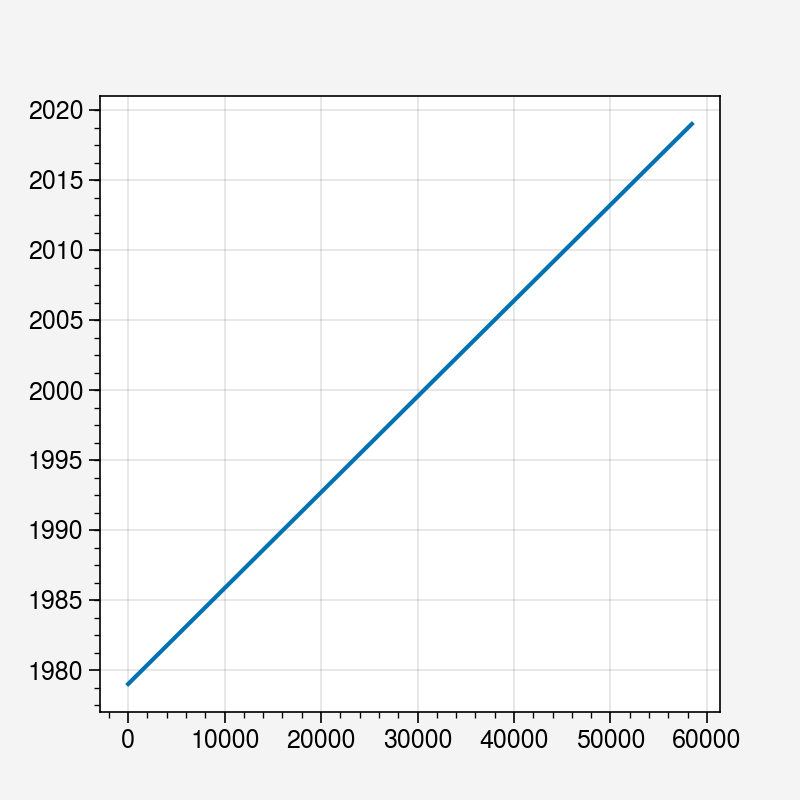

In [14]:
plt.plot(ds_features['time'])

In [15]:
ds_target_tval

<xarray.Dataset>
Dimensions:    (time: 13880)
Coordinates:
    dayofyear  (time) int64 1 2 3 4 5 6 7 8 ... 359 360 361 362 363 364 365 366
  * time       (time) datetime64[ns] 1979-01-01T12:00:00 ... 2016-12-31
Data variables:
    precip     (time) float64 dask.array<chunksize=(1,), meta=np.ndarray>

### Write out train and test data

ds_features_tval.to_netcdf('../data/cnn/features_trainval.nc')
ds_features_test.to_netcdf('../data/cnn/features_test.nc')
ds_target_tval.to_netcdf('../data/cnn/target_trainval.nc')
ds_target_test.to_netcdf('../data/cnn/target_test.nc')